# Fashion Mnist - MobileNetv2

## Import Libraries

In [1]:
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# from utils import mnist_reader # Download from Fashion Mnist repo
from utils import mnist_reader

## Download and Load Data

In [2]:
# Download Data if needed
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

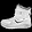

In [3]:
# Load Data
# Change Data folder respectively
data_folder = "./data"

train_images1, train_labels = mnist_reader.load_mnist(data_folder, "train")
test_images1, test_labels = mnist_reader.load_mnist(data_folder, "t10k")

train_images1 = train_images1.reshape(-1, 28,28)
test_images1 = test_images1.reshape(-1, 28,28)
# train_images.shape

image = Image.fromarray(train_images1[0])
image = image.resize((32,32))
image

In [4]:
import cv2
from PIL import Image

train_images = []
test_images = []

for i in train_images1:
  # train_images.append(cv2.resize(i, (32,32), cv2.INTER_CUBIC))
  train_images.append(np.array(Image.fromarray(i).resize((32,32))))
  

for i in test_images1:
  # test_images.append(cv2.resize(i, (32,32), cv2.INTER_CUBIC))
  test_images.append(np.array(Image.fromarray(i).resize((32,32))))

train_images = np.array(train_images)
test_images = np.array(test_images)
train_images.shape

(60000, 32, 32)

## Basic Data Visualization

In [5]:
def visualize_data(data, target, title="Train Data Visualization"):
  labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  # Set the figure size
  fig = plt.figure(figsize=(10,10))
  # Show only the first 50 pictures
  plt.suptitle(title)
  # Inex range
  index_l = random.sample(range(0, len(target)), 30)
  for i in range(25):
      plt.subplot(5,5, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(data[index_l[i]], cmap=plt.cm.binary)
      plt.xlabel(labels[target[index_l[i]]])
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

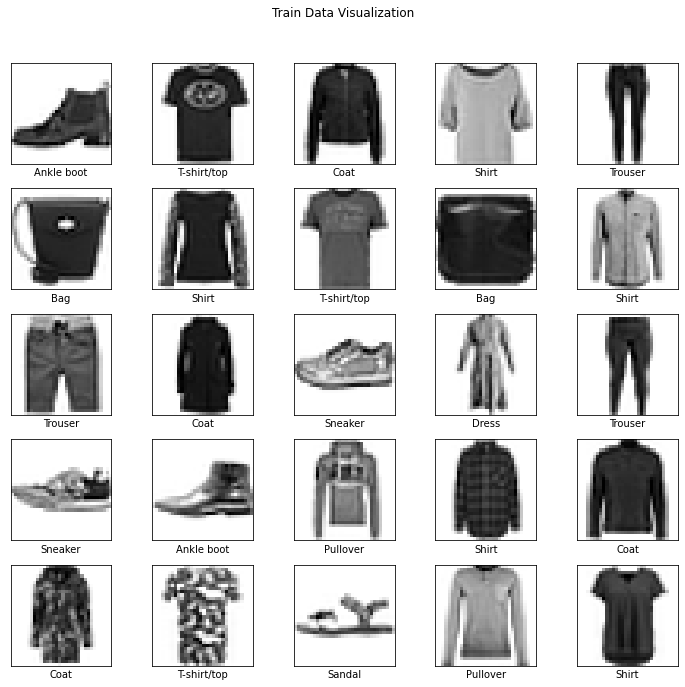

In [6]:
visualize_data(train_images, train_labels)

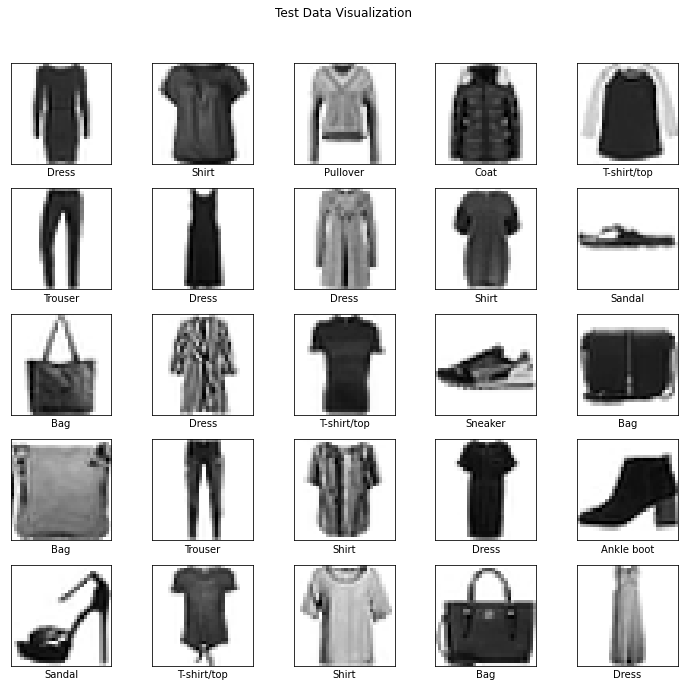

In [7]:
visualize_data(test_images, test_labels, "Test Data Visualization")

## Load MobileNetv2 Model Trained on ImageNet Data

In [8]:
# Load the pre trained model
# Top is not included for us to customize
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,
    weights='imagenet')

# If u want to freeze
# base_model.trainable = False

## Convert Image to 3 Channel Images (Colored) from a Gray Scale

In [9]:
train_images = np.stack((train_images,)*3, axis=-1)

In [10]:
test_images = np.stack((test_images,)*3, axis=-1)

In [11]:
train_images.shape

(60000, 32, 32, 3)

## Convert Target Labels to One Hot Encoding 

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
encoder = OneHotEncoder(sparse=False)
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_oh = encoder.transform(test_labels.reshape(-1, 1))

In [14]:
train_labels_oh

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
train_labels_oh.shape

(60000, 10)

## Build Model

In [16]:
def get_model(input_shape=(32, 32, 3)):                  # Changed to 32x32 because MobileNet accepts images that are 32*32 and above 
  input = tf.keras.layers.Input(shape=input_shape)
  x = base_model(input)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128)(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  x = tf.keras.layers.Dense(32)(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

  model = tf.keras.Model(inputs=input, outputs=outputs)
  model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics="acc")
  return model

In [17]:
model = get_model()

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                             

## Model Training

In [19]:
# Possbile Callbacks
# model check pointer
# early stopping
# learning rate scheduler *optional

# Build Callbacks
MC = tf.keras.callbacks.ModelCheckpoint(
    "models/mobilenetv2.h5",
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only = False
)

ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4
)

In [20]:
# If kernel crashes or you get an resource exhauseted error, reduce batch size, always use powers of 2 eg: 32, 62, 128...
history = model.fit(train_images, train_labels_oh, epochs=1000, batch_size=1024,validation_split=0.1, callbacks=[MC, ES])

Epoch 1/1000
53/53 [==============================] - ETA: 0s - loss: 1.0273 - acc: 0.7104

C:\Users\Lasal Jayawardena\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


53/53 [==============================] - 19s 176ms/step - loss: 1.0273 - acc: 0.7104 - val_loss: 21.9187 - val_acc: 0.1567
Epoch 2/1000
53/53 [==============================] - 6s 121ms/step - loss: 0.4070 - acc: 0.8618 - val_loss: 12.0126 - val_acc: 0.2328
Epoch 3/1000
53/53 [==============================] - 7s 126ms/step - loss: 0.3137 - acc: 0.8923 - val_loss: 10.1037 - val_acc: 0.2798
Epoch 4/1000
53/53 [==============================] - 6s 113ms/step - loss: 0.2530 - acc: 0.9126 - val_loss: 12.2006 - val_acc: 0.2107
Epoch 5/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.2193 - acc: 0.9238 - val_loss: 10.2012 - val_acc: 0.2508
Epoch 6/1000
53/53 [==============================] - 7s 134ms/step - loss: 0.1985 - acc: 0.9316 - val_loss: 9.9663 - val_acc: 0.2362
Epoch 7/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.1679 - acc: 0.9419 - val_loss: 8.9525 - val_acc: 0.2887
Epoch 8/1000
53/53 [==============================] - 6s 113ms/step -

## Training Assesment

In [21]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

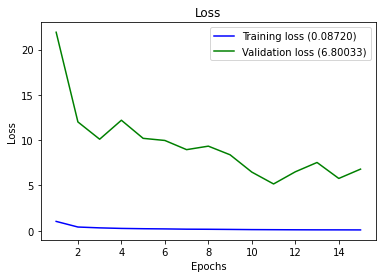

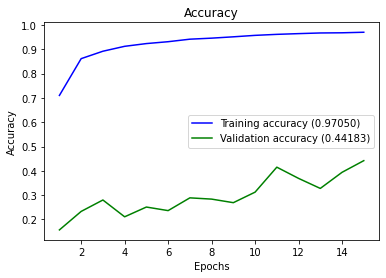

In [22]:
# Plot Loss and Accuracy of Training History
plot_history(history)

## Model Evaluation

In [11]:
# load best model
best_model = tf.keras.models.load_model("./models/mobilenetv2.h5")

In [24]:
best_model.evaluate(test_images, test_labels_oh)

313/313 [==============================] - 5s 14ms/step - loss: 6.8374 - acc: 0.4383


[6.837368965148926, 0.4383000135421753]

In [25]:
predictions = best_model.predict(test_images)
# Get the Single labels from predction instead of an array of probabilities
predictions = np.argmax(predictions, axis=1)

In [26]:
# Accuracy on the Test Set
test_acc = accuracy_score(test_labels, predictions)
print(f"Test Accuracy is {test_acc*100}%")

Test Accuracy is 43.830000000000005%


In [27]:
# Classification Report
print(classification_report(test_labels, predictions, target_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']))

              precision    recall  f1-score   support

 T-shirt/top       0.00      0.00      0.00      1000
     Trouser       0.00      0.00      0.00      1000
    Pullover       0.55      0.05      0.09      1000
       Dress       0.54      0.19      0.28      1000
        Coat       0.54      0.79      0.64      1000
      Sandal       0.00      0.00      0.00      1000
       Shirt       0.16      0.81      0.26      1000
     Sneaker       0.86      0.81      0.83      1000
         Bag       0.97      0.79      0.87      1000
  Ankle boot       0.79      0.96      0.87      1000

    accuracy                           0.44     10000
   macro avg       0.44      0.44      0.38     10000
weighted avg       0.44      0.44      0.38     10000



C:\Users\Lasal Jayawardena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lasal Jayawardena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lasal Jayawardena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
def plot_confusion_matrix(y_test, y_pred):
    labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (20, 10))
    cm = pd.DataFrame(cm , index = [i for i in labels] , columns = [i for i in labels])
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
    plt.title('Fashion Mnist Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

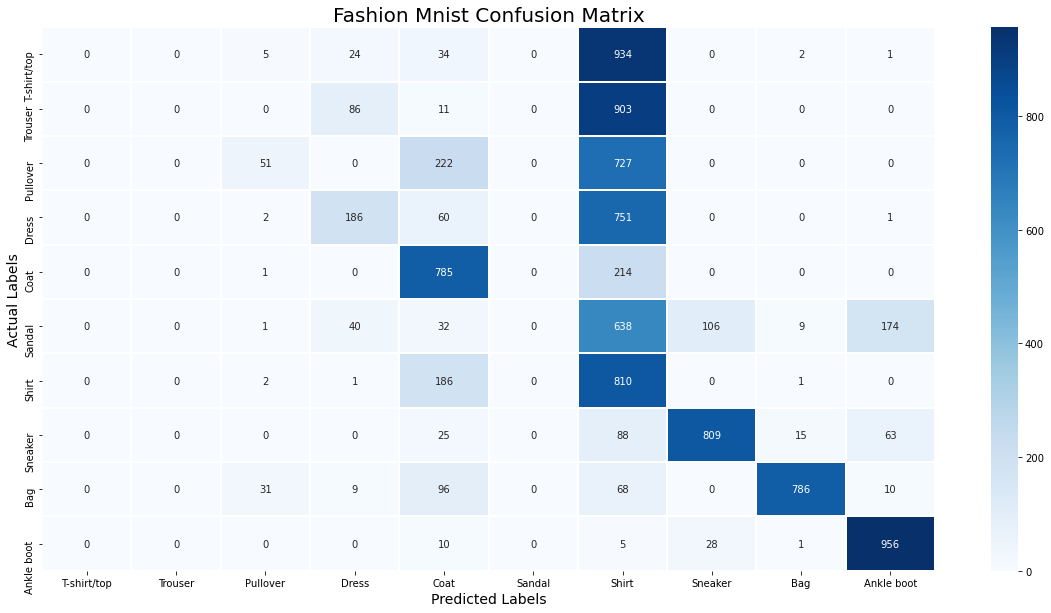

In [29]:
plot_confusion_matrix(test_labels, predictions)

## Summary

- Test Accuracy is 10.24%
- Model F1 Score is 2%
- Model Precision is 24%
- Model Recall is 10%
- Best Perfoming Class is "Trouser" ***
- Worst Performing Class is "Shirt"  ***
- Model only accpeted Images with 3 Channels, Image size was flexible but the input image size should be greater than 32x32.

In [12]:
from tqdm import tqdm
import time

In [13]:
def get_inference_speed(model, data=test_images[:500]):
    #  GPU warm up
    model.predict(data)
    
    start_time = time.time()
    for i in tqdm(range(100)):
        model.predict(data)
    end_time = time.time()
    speed = (end_time - start_time) / (100 * len(data))
    return speed * 1000

In [14]:
get_inference_speed(best_model)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.62it/s]


0.4328479385375977